In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob
import scipy.io as scio
from os import *
import sys
import time
import seaborn as sns
from scipy.stats import gaussian_kde
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

Get the input and output data from .mat dataset

In [2]:
data=scio.loadmat("trainA.mat")
input_d=data['input']
output_d=data['output']
predict_in=data['predict_in']
predict_out=data['predict_out']


In [3]:
output_d

array([[ 7.     ,  1.     ,  0.     ,  0.18705],
       [ 7.     ,  1.     ,  0.5    ,  0.17305],
       [ 7.     ,  1.     ,  1.     ,  0.1611 ],
       ...,
       [12.     , 31.     , 22.5    ,  0.46154],
       [12.     , 31.     , 23.     ,  0.4448 ],
       [12.     , 31.     , 23.5    ,  0.43571]])

Data visulization


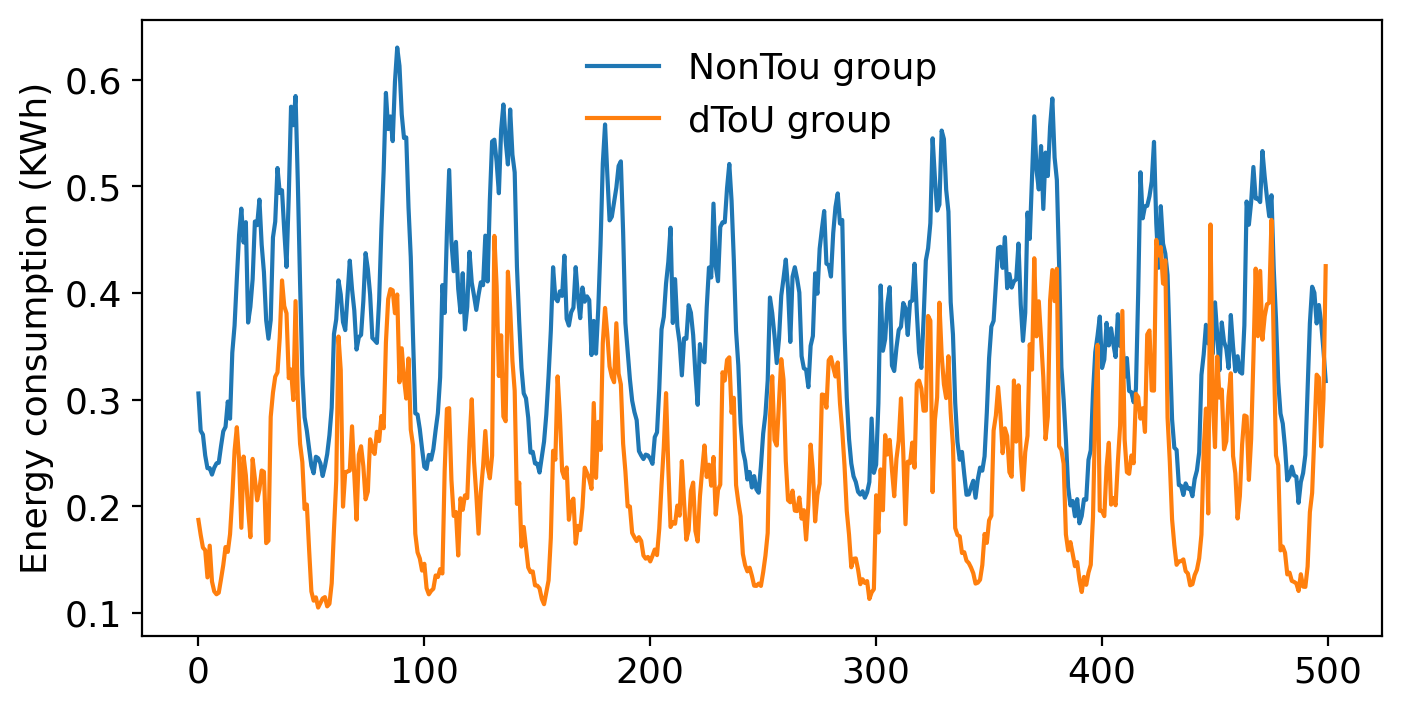

In [4]:
fig, axes = plt.subplots(1, 1, figsize=(8,4))
x = range(0,500)
label1='NonTou group'
label2='dToU group'
axes.plot(x, input_d[0:500,3], label=label1)
axes.set_ylabel("Energy consumption (KWh)")
axes.plot(x, output_d[0:500,3], label=label2)
axes.legend()


Data prepare

In [5]:
numsize=0.7
numsample=len(input_d)

num_train=round(numsize*numsample)

X_train_df = input_d[0:num_train,1:4]
y_train_df = output_d[0:num_train,3:4]

X_test_df = input_d[num_train:,1:4]
y_test_df = output_d[num_train:,3:4]



In [6]:
# Standardization
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

X_train = X_train_df
y_train = y_train_df
X_test = X_test_df
y_test = y_test_df 

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(16733, 3) (16733, 1)
(7171, 3) (7171, 1)


In [7]:
column_names = ['Day', 'Hour', 'Demand']

df = pd.DataFrame(X_train, columns=column_names)
df.head()

Day      Hour    Demand
0 -0.898733 -1.009049 -0.975330
1 -0.898733 -0.953891 -0.979187
2 -0.898733 -0.898733 -0.979584
3 -0.898733 -0.843575 -0.981739
4 -0.898733 -0.788417 -0.983060

(16733, 2)


<AxesSubplot:>

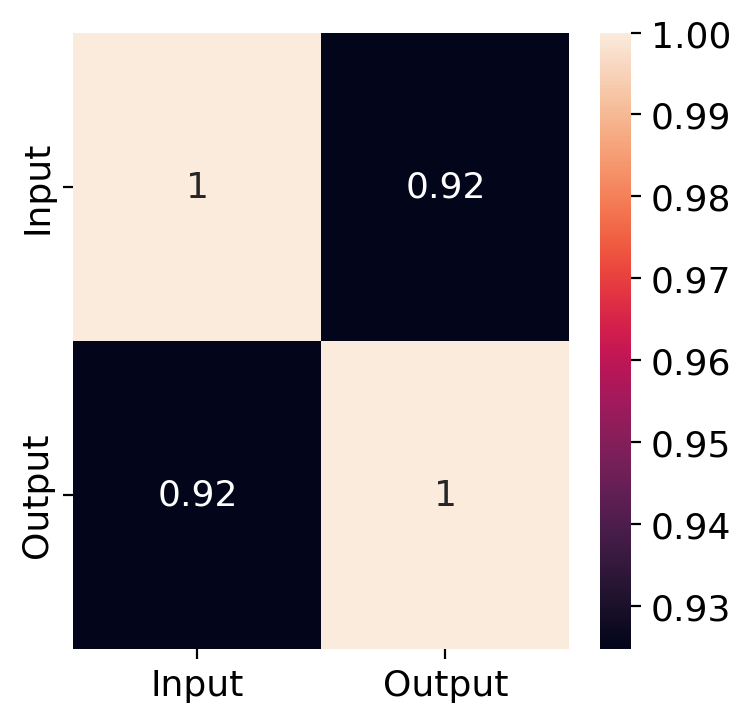

In [8]:
column_names = ['Input', 'Output']

data11=np.hstack((X_train[:,2:3],y_train))

print(data11.shape)
df1=pd.DataFrame(data11, columns=column_names)
plt.figure(figsize=(4,4))
cor=df1.corr()
sns.heatmap(cor,annot=True)

### 2. Define the NN structure

In [9]:
t=time.perf_counter()
# set hyperparameters
n_neuron       = 32
activation     = 'relu'
num_epochs     = 300
learning_rate  = 0.001
minibatch_size = 32
model_num      = 1

In [10]:
model = Sequential()

model.add(Dense(n_neuron,  activation=activation,input_shape=(X_train.shape[1],))) #  the 1st hidden layer 
model.add(Dense(n_neuron,  activation=activation)) # the 2nd hidden layer
model.add(Dense(n_neuron,  activation=activation)) # the 3rd hidden layer
model.add(Dense(n_neuron,  activation=activation)) # the 4rd hidden layer

model.add(Dense(1)) # the output layer
#model.add(Dense(y_train.shape[0],  activation='linear')) # the output layer

model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

2022-12-23 10:49:33.707019: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                128       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,329
Trainable params: 3,329
Non-trainable params: 0
_________________________________________________________________


### 3. Train & save the NN model

In [12]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history = model.fit(X_train, y_train, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.2, 
                    verbose         = 1,
                    callbacks       = [early_stop])


Epoch 1/300
419/419 [==============================] - 0s 718us/step - loss: 0.0166 - val_loss: 0.0077
Epoch 2/300
419/419 [==============================] - 0s 555us/step - loss: 0.0086 - val_loss: 0.0114
Epoch 3/300
419/419 [==============================] - 0s 555us/step - loss: 0.0083 - val_loss: 0.0074
Epoch 4/300
419/419 [==============================] - 0s 555us/step - loss: 0.0082 - val_loss: 0.0106
Epoch 5/300
419/419 [==============================] - 0s 555us/step - loss: 0.0080 - val_loss: 0.0095
Epoch 6/300
419/419 [==============================] - 0s 554us/step - loss: 0.0080 - val_loss: 0.0089
Epoch 7/300
419/419 [==============================] - 0s 554us/step - loss: 0.0079 - val_loss: 0.0077
Epoch 8/300
419/419 [==============================] - 0s 553us/step - loss: 0.0077 - val_loss: 0.0080
Epoch 9/300
419/419 [==============================] - 0s 554us/step - loss: 0.0077 - val_loss: 0.0062
Epoch 10/300
419/419 [==============================] - 0s 555us/step - l

Text(0.5, 1.0, 'NN')

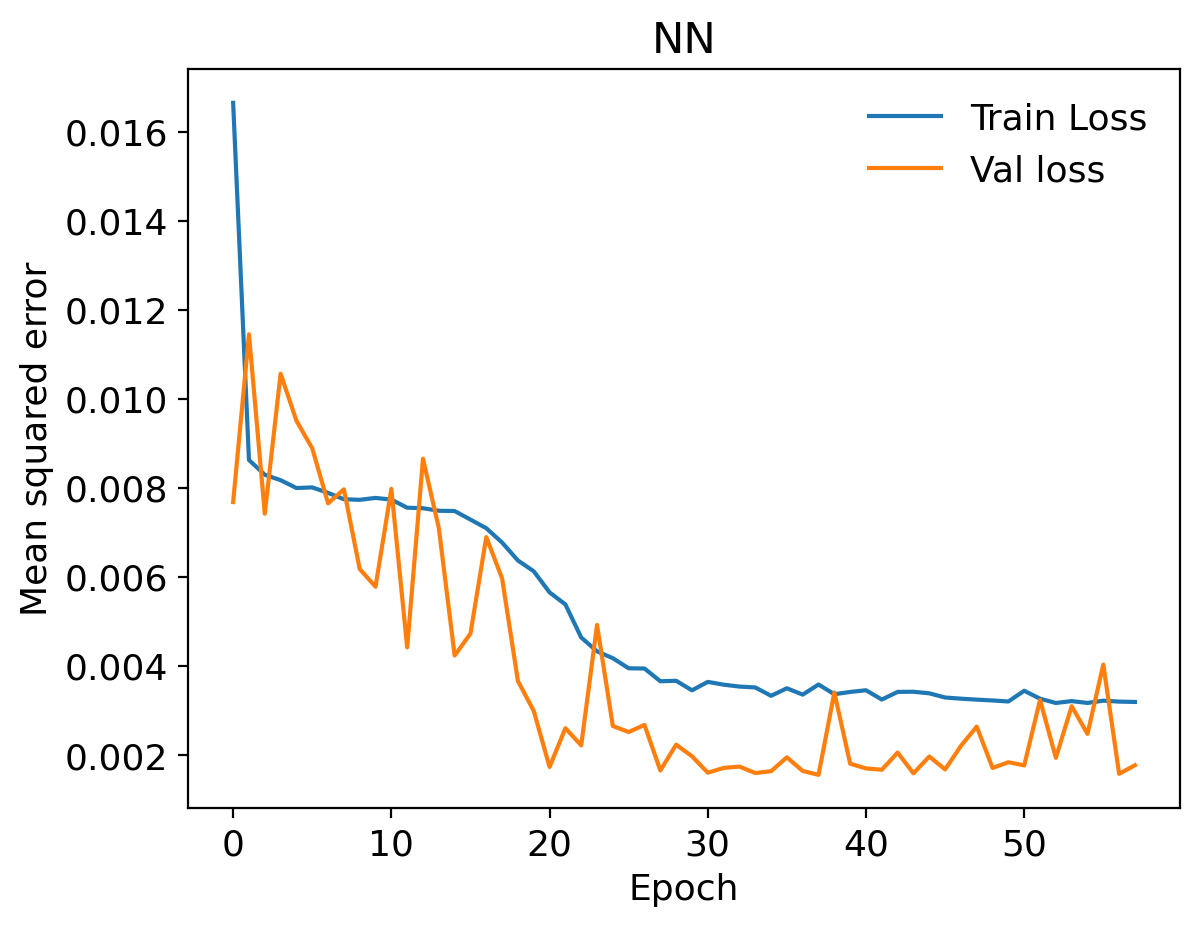

In [13]:
plot_history(history)
plt.title('NN')

In [14]:
model_path = os.path.join('saved_model')
make_dir(model_path)

In [15]:
model.save(os.path.join(model_path,'NN_model.h5'))
print(f'coast:{time.perf_counter() - t:.8f}s' )

coast:14.41995425s


### 4. Evaluate the trained model

Now let's evaluate the trained NN on the test set, by comparing the NN predictions against the tas originally simulated under the ssp245 scenario. 

In [16]:
model = load_model(os.path.join(model_path,'NN_model.h5'))

In [17]:
y_test_pre = model.predict(X_test)


225/225 [==============================] - 0s 299us/step


In [18]:
np.shape(y_test_pre)

(7171, 1)

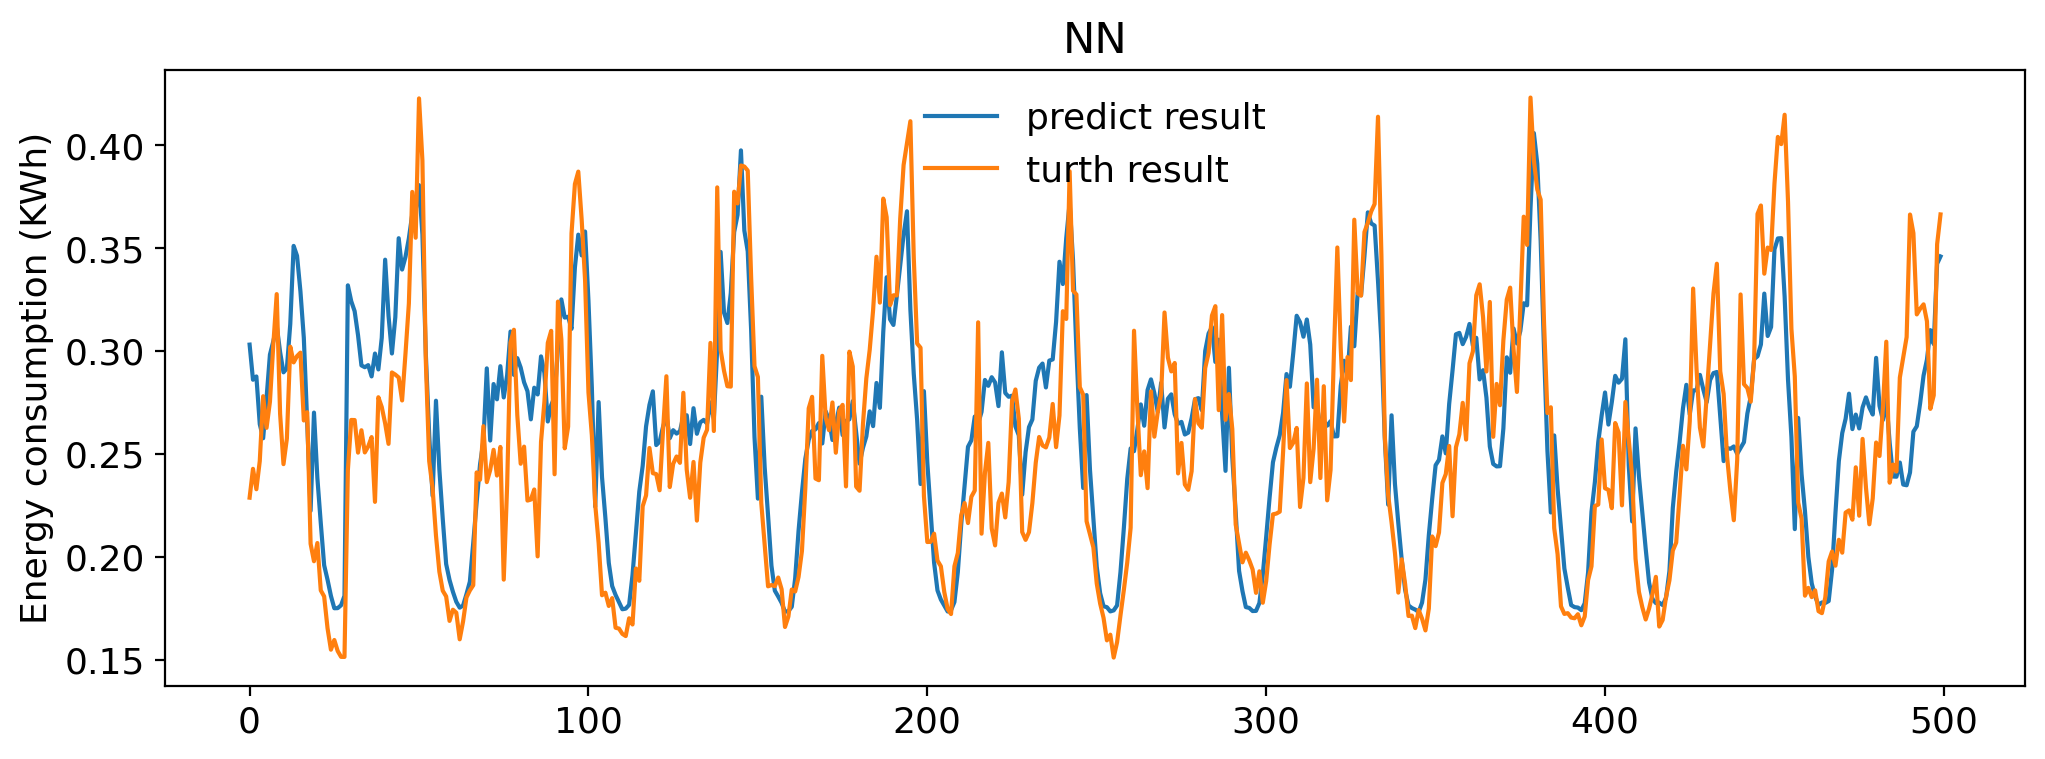

In [19]:
fig, axes = plt.subplots(1, 1, figsize=(12,4))
x = range(0,500)
label1='predict result'
label2='turth result'
axes.plot(x, y_test_pre[0:500], label=label1)
axes.set_ylabel("Energy consumption (KWh)")
axes.plot(x, y_test[0:500], label=label2)
plt.title('NN')
axes.legend()


In [20]:
RMSE=np.sqrt(np.mean((y_test_pre-y_test)**2))
MAPE=np.mean(abs(y_test-y_test_pre)/y_test)*100
print(RMSE,MAPE)

0.04886367448198499 12.398962465437354


In [21]:
print(y_test_pre.shape)
print(y_test.shape)


(7171, 1)
(7171, 1)


<AxesSubplot:>

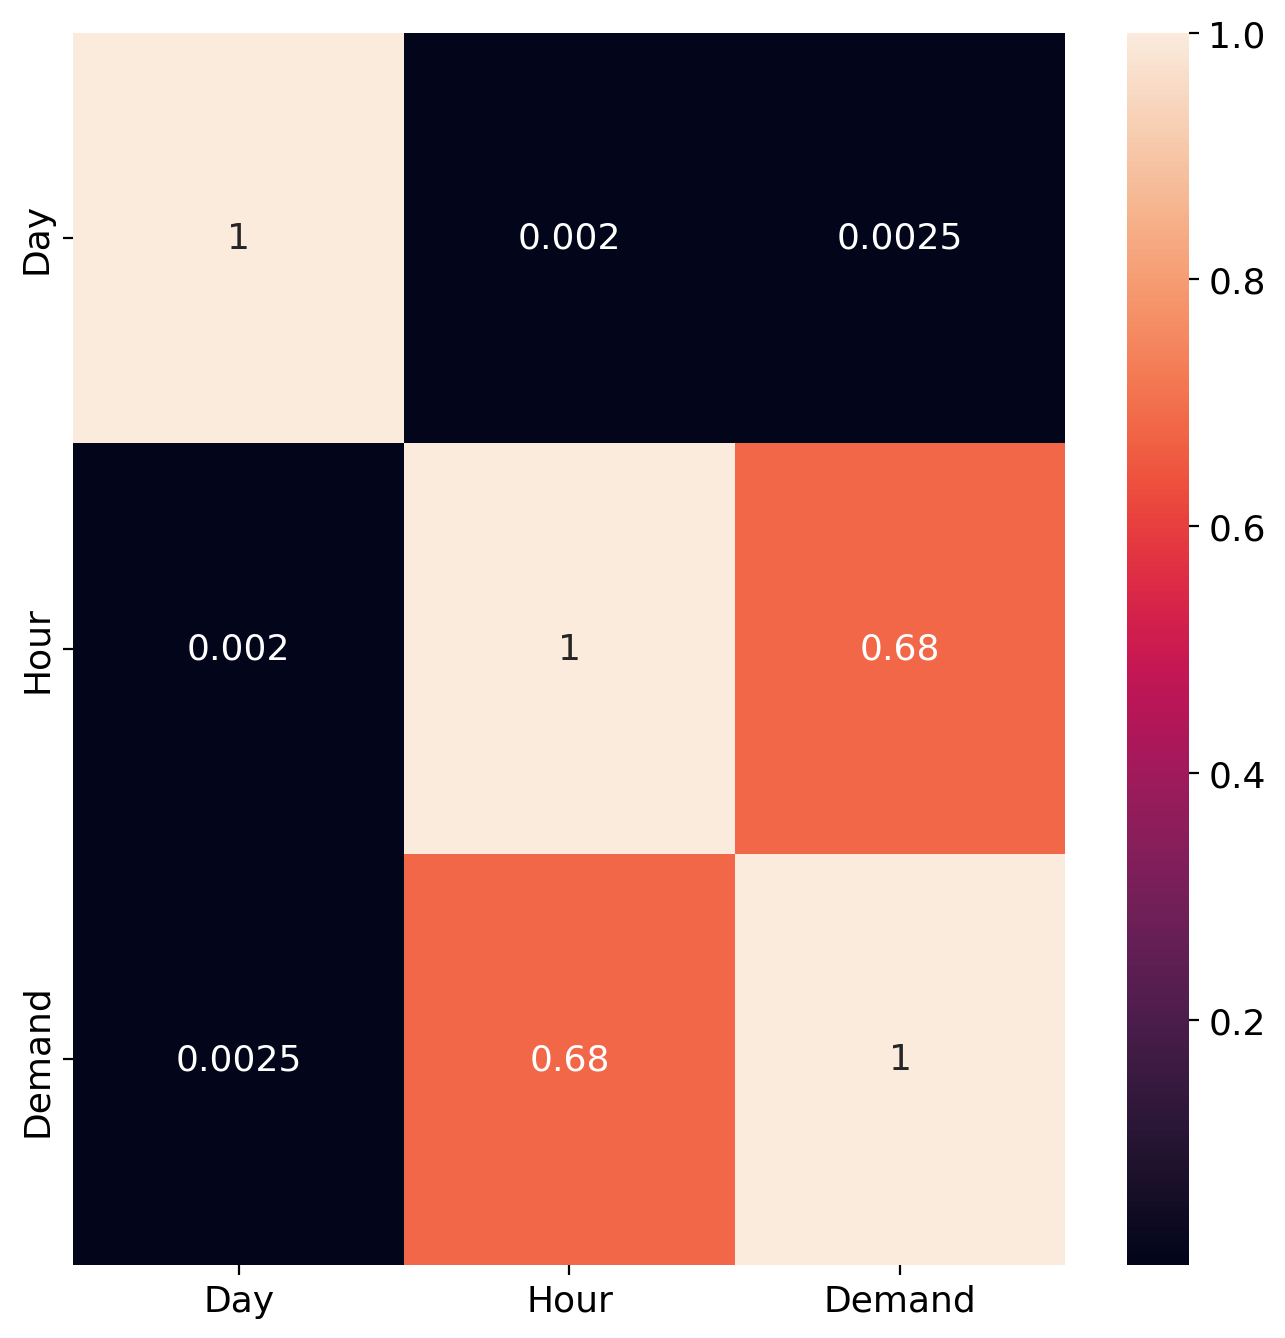

In [22]:
plt.figure(figsize=(8,8))
cor=df.corr()
sns.heatmap(cor,annot=True)
#cmap=plt.cm.Reds,fmt='.2f'

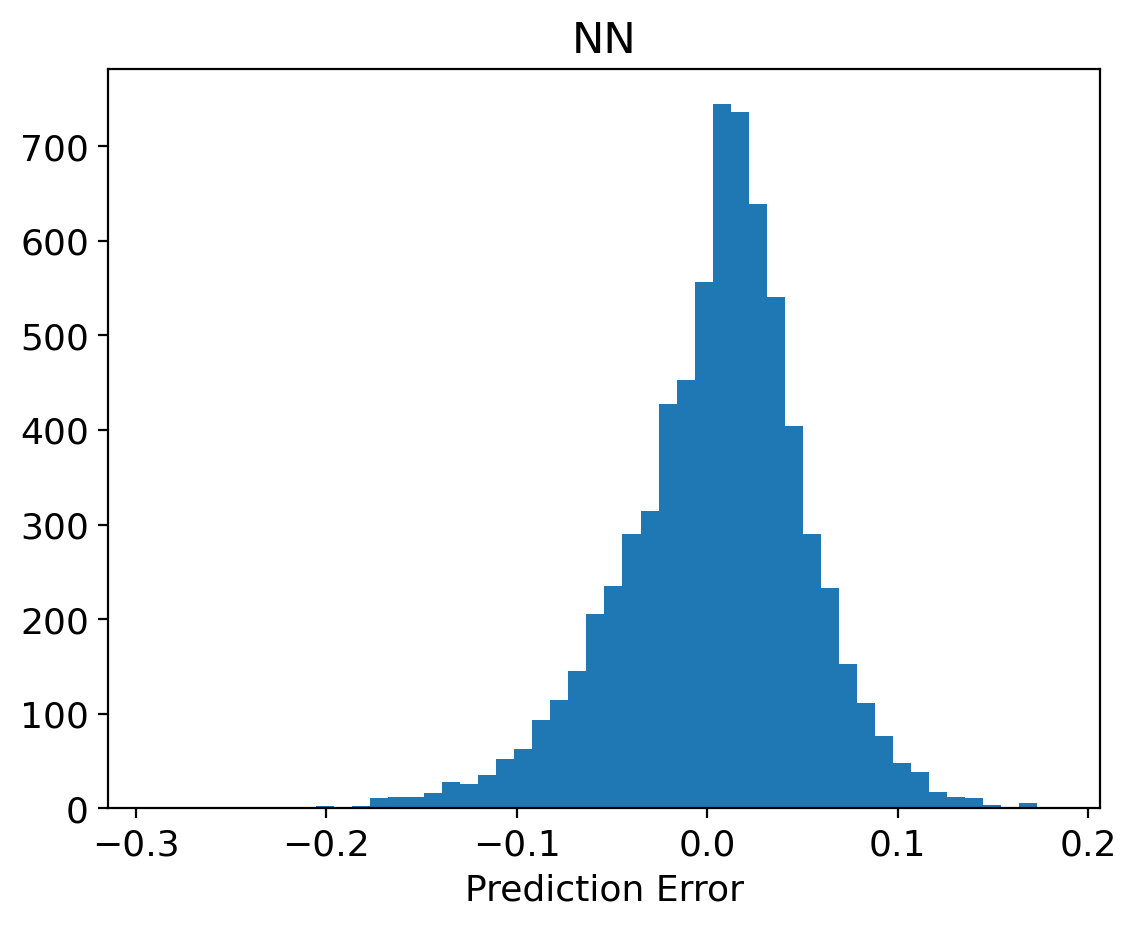

In [23]:
# histogram
error = y_test_pre - y_test
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error")

plt.title('NN')
plt.show()

0.8471378592627183

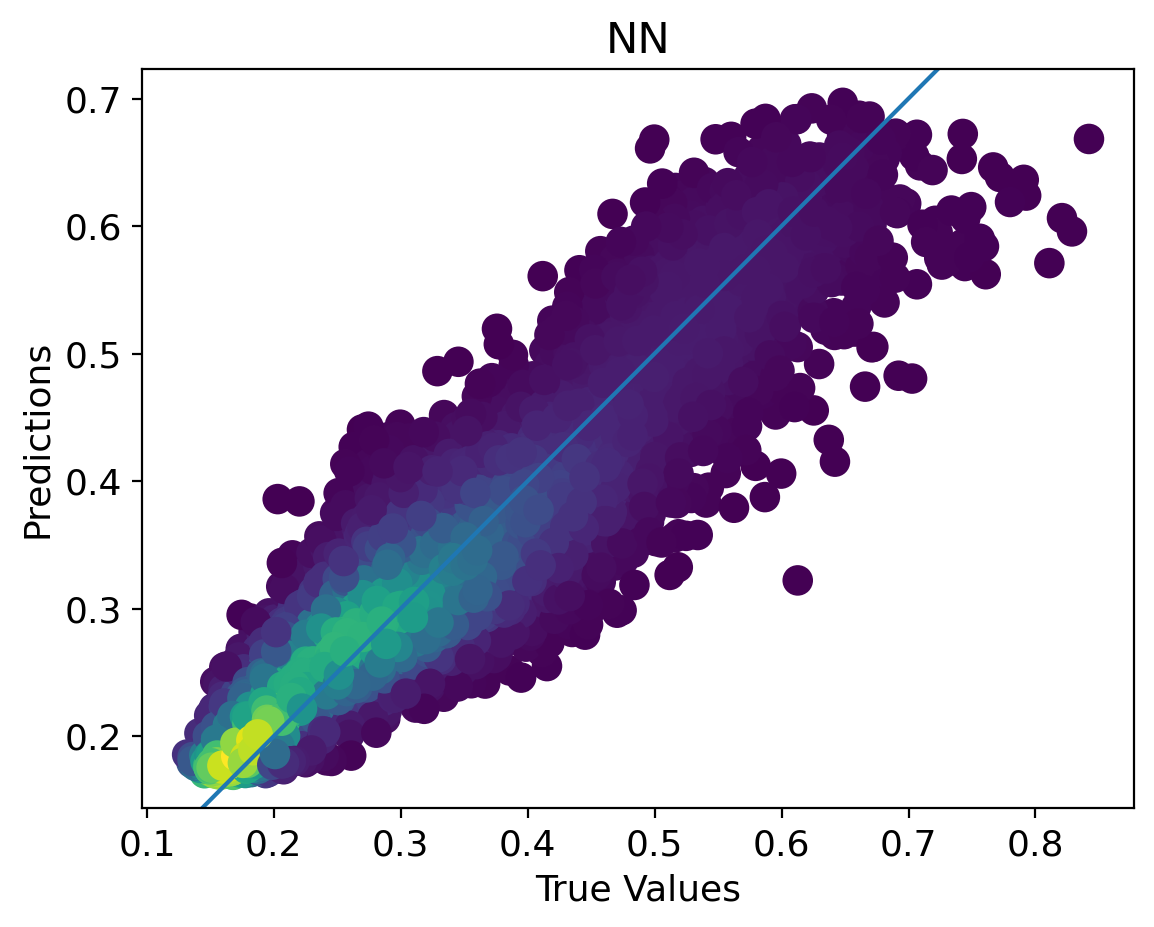

In [24]:
# relationship between true and predicted value
import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap

xy = np.vstack([np.transpose(y_test),np.transpose(y_test_pre)])
z = gaussian_kde(xy)(xy)
fig, ax = plt.subplots()
ax.scatter(y_test, y_test_pre, c=z, s=100)
#plt.show()

#plt.scatter(y_test, y_test_pre)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.title('NN')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
_ = plt.plot([-100, 100], [-100, 100])
from sklearn.metrics import r2_score
r2_score(y_test,y_test_pre)

/opt/anaconda3/envs/Opt/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Exact explainer: 16734it [00:31, 380.84it/s]                                    


.values =
array([[ 0.02393945,  0.04530275, -0.0513759 ],
       [ 0.02286686,  0.01258456, -0.06537708],
       [ 0.01841673, -0.02150183, -0.06562694],
       ...,
       [ 0.00820745,  0.02372757, -0.0816287 ],
       [ 0.00981579,  0.02072747, -0.0611952 ],
       [ 0.01023622,  0.01625526, -0.07162094]])

.base_values =
array([[0.3255787],
       [0.3255787],
       [0.3255787],
       ...,
       [0.3255787],
       [0.3255787],
       [0.3255787]])

.data =
array([[-0.89873314, -1.00904883, -0.97532974],
       [-0.89873314, -0.95389098, -0.97918748],
       [-0.89873314, -0.89873314, -0.97958351],
       ...,
       [ 0.42505517,  0.42505517, -0.97855868],
       [ 0.42505517,  0.48021302, -0.97396182],
       [ 0.42505517,  0.53537087, -0.97627845]])


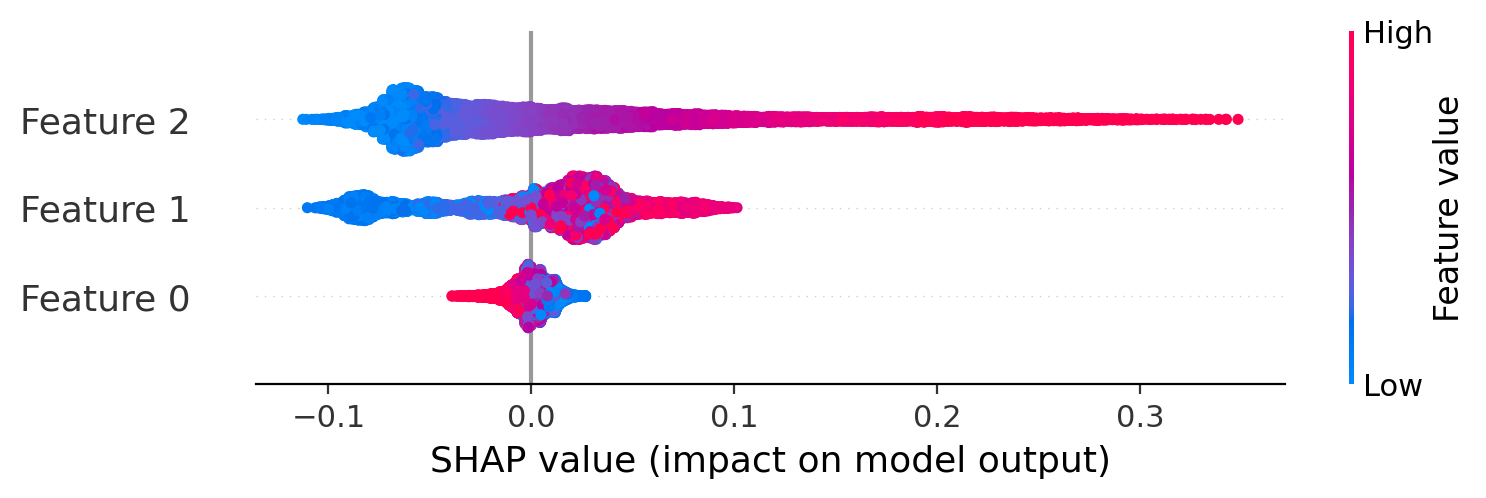

In [25]:
import shap

explainer = shap.Explainer(model, X_train)
print(explainer)
#explain_data = X_train[np.random.choice(X_train.shape[0], 10, replace=False)]
explain_data = X_train[:]
shap_values = explainer(explain_data)
print(shap_values)
shap.summary_plot(shap_values, explain_data)
#shap_value=explainer(X_train)
#shap.waterfall_plot(shap_values.base_values[0], shap_values.values[0], shap_values.data[0])
#shap.plots.waterfall(shap_values[0])

In [26]:
shap.initjs()
shap.force_plot( shap_values[134,:], X_train[134,:])

In [27]:
#explainer = shap.TreeExplainer(model)
#shap_interaction = explainer.shap_interaction_values(X_train)